# Forecasting Absenteeism in the Workplace with Supervised Learning


The goal of this project is to explore and analyze employee absenteeism data to uncover patterns and key influencing factors. Through exploratory data analysis (EDA), we aim to identify trends such as seasonal peaks in absenteeism and correlations between personal habits (e.g., smoking or drinking) and absence hours. Following this, we will develop both a linear regression model to predict the number of hours employees are absent from work and a logistic regression model to classify whether an employee is likely to be absent or not. Additionally, we will compare these results to those from a random forest model to assess any potential improvement in predictive performance.
These models will support proactive decision-making in workforce management.

## Columns description

- **ID**: Unique identifier for each employee.

- **Reason for absence**: Categorical code indicating the reason for an employee's absence, divided into three groups:
(0: No absence (employee was present), 1–21: Medical reasons (e.g., illness, mental health, respiratory or musculoskeletal conditions), 22–28: Non-medical reasons (e.g., personal issues, medical appointments, legal matters))

- **Month of absence**: Month (1–12) during which the absence occurred.

- **Day of the week**: Day of the week (2 = Monday, 6 = Friday) when the absence was recorded.

- **Seasons**: Season in which the absence occurred (1 = Summer, 2 = Autumn, 3 = Winter, 4 = Spring).

- **Transportation expense**: Monthly transportation cost in monetary units.

- **Distance from Residence to Work**: Distance in kilometers between the employee’s home and workplace.

- **Service time**: Number of years the employee has been with the company.

- **Age**: Employee's age in years.

- **Work load Average/day**: Daily average workload measured in units (standardized).

- **Hit target**: Percentage of monthly targets achieved by the employee.

- **Disciplinary failure**: Binary variable indicating disciplinary infractions (0 = No, 1 = Yes).

- **Education**: Education level (1 = High School, 2 = Graduate, 3 = Postgraduate, 4 = Master/PhD).

- **Son**: Number of children the employee has.

- **Social drinker**: Indicates if the employee drinks socially (0 = No, 1 = Yes).

- **Social smoker**: Indicates if the employee smokes socially (0 = No, 1 = Yes).

- **Pet**: Number of pets the employee owns.

- **Weight**: Employee’s weight in kilograms.

- **Height**: Employee’s height in centimeters.

- **Body mass index**: BMI, calculated from weight and height.

- **Absenteeism time in hours**: Total number of work hours missed due to absence (target variable).


## Libraries

In [10]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from itertools import product

## Import dataset

In [11]:
# Main data
df = pd.read_csv("D:\PythonProjects\DATASET\Absenteism\Absenteeism_at_work.csv", sep = ";")

print(f"Rows, Columns: {df.shape}\n")
HTML("<div style='overflow-x: auto'>" + df.head().to_html() + "</div>")

Rows, Columns: (740, 21)



,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


## Data Cleaning

### Missing values and duplicates

It is not possible to determine whether records are duplicated, as there is no primary key and entries with the same day of the week may correspond to different days of the month.

In [12]:
# Missing values
print(f"Missing values:\n{df.isnull().sum()}")

Missing values:
ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64


### Records with no absence

These records are not necessary to predict the duration of absences.



In [13]:
isNotAbsent = (df['Absenteeism time in hours'] == 0).sum()
print(f"Records with no absence: {(isNotAbsent/df.shape[0]*100):.2f}%")

# Remove records
df = df.loc[df['Absenteeism time in hours'] > 0]

Records with no absence: 5.95%


### Month/Season assessment

In [14]:
month_season = df[['Month of absence','Seasons']].drop_duplicates().sort_values(['Month of absence','Seasons'])
HTML("<div style='overflow-x: auto'>" + month_season.to_html() + "</div>")

,Month of absence,Seasons
113,1,2
137,2,2
155,3,2
175,3,3
184,4,3
204,5,3
234,6,1
220,6,3
0,7,1
19,8,1


**Key observations:**

Some seasons are incorrect (e.g. index = 113, 50, etc.).



In [15]:
# Fix the season for all months (except March, June, September, December)
def assign_season(month):
  if month in list(range(1, 3)):
    return 3
  elif month in list(range(4, 6)):
    return 4
  elif month in list(range(7, 9)):
    return 1
  elif month in list(range(10, 12)):
    return 2
  else:
    return np.nan

# Apply
df['newSeason'] = df['Month of absence'].apply(assign_season)

#Fix the season for the months of season transition (March, June, September, December)
df.loc[(df['Month of absence'] == 3) & (df['Seasons'] == 2),'newSeason'] = 4
df.loc[(df['Month of absence'] == 6) & (df['Seasons'] == 3),'newSeason'] = 4
df.loc[(df['Month of absence'] == 9) & (df['Seasons'] == 4),'newSeason'] = 2
df.loc[(df['Month of absence'] == 12) & (df['Seasons'] == 4),'newSeason'] = 3
df.loc[df['newSeason'].isna(),'newSeason'] = df['Seasons']

# Convert the data type
df['newSeason'] = df['newSeason'].astype('int')

# Remove the original season column
df.drop(columns = 'Seasons', inplace=True)

# Rename the new season column
df.rename(columns = {'newSeason':'Season'}, inplace=True)

## Exploratory Data Analysis

### Analysis of quantitative variables

In [16]:
col = ["Transportation expense","Distance from Residence to Work", "Service time", "Age","Absenteeism time in hours",'Work load Average/day ','Hit target', 'Weight', 'Height', 'Body mass index']

# Statistics summary
HTML("<div style='overflow-x: auto'>" + df[col].describe().to_html() + "</div>")

,Transportation expense,Distance from Residence to Work,Service time,Age,Absenteeism time in hours,Work load Average/day,Hit target,Weight,Height,Body mass index
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,219.916667,29.853448,12.553161,36.254310,7.362069,271.165718,94.719828,78.751437,172.132184,26.573276
std,65.803295,14.855615,4.440175,6.380725,13.628618,39.096003,3.656150,12.730748,6.087118,4.192879
min,118.000000,5.000000,1.000000,27.000000,1.000000,205.917000,81.000000,56.000000,163.000000,19.000000
25%,179.000000,16.000000,9.000000,31.000000,2.000000,243.659250,93.000000,69.000000,169.000000,24.000000
50%,225.000000,26.000000,13.000000,37.000000,3.000000,264.249000,95.000000,80.000000,170.000000,25.000000
75%,260.000000,50.000000,16.000000,40.000000,8.000000,294.217000,97.000000,89.000000,172.000000,31.000000
max,388.000000,52.000000,29.000000,58.000000,120.000000,378.884000,100.000000,108.000000,196.000000,38.000000


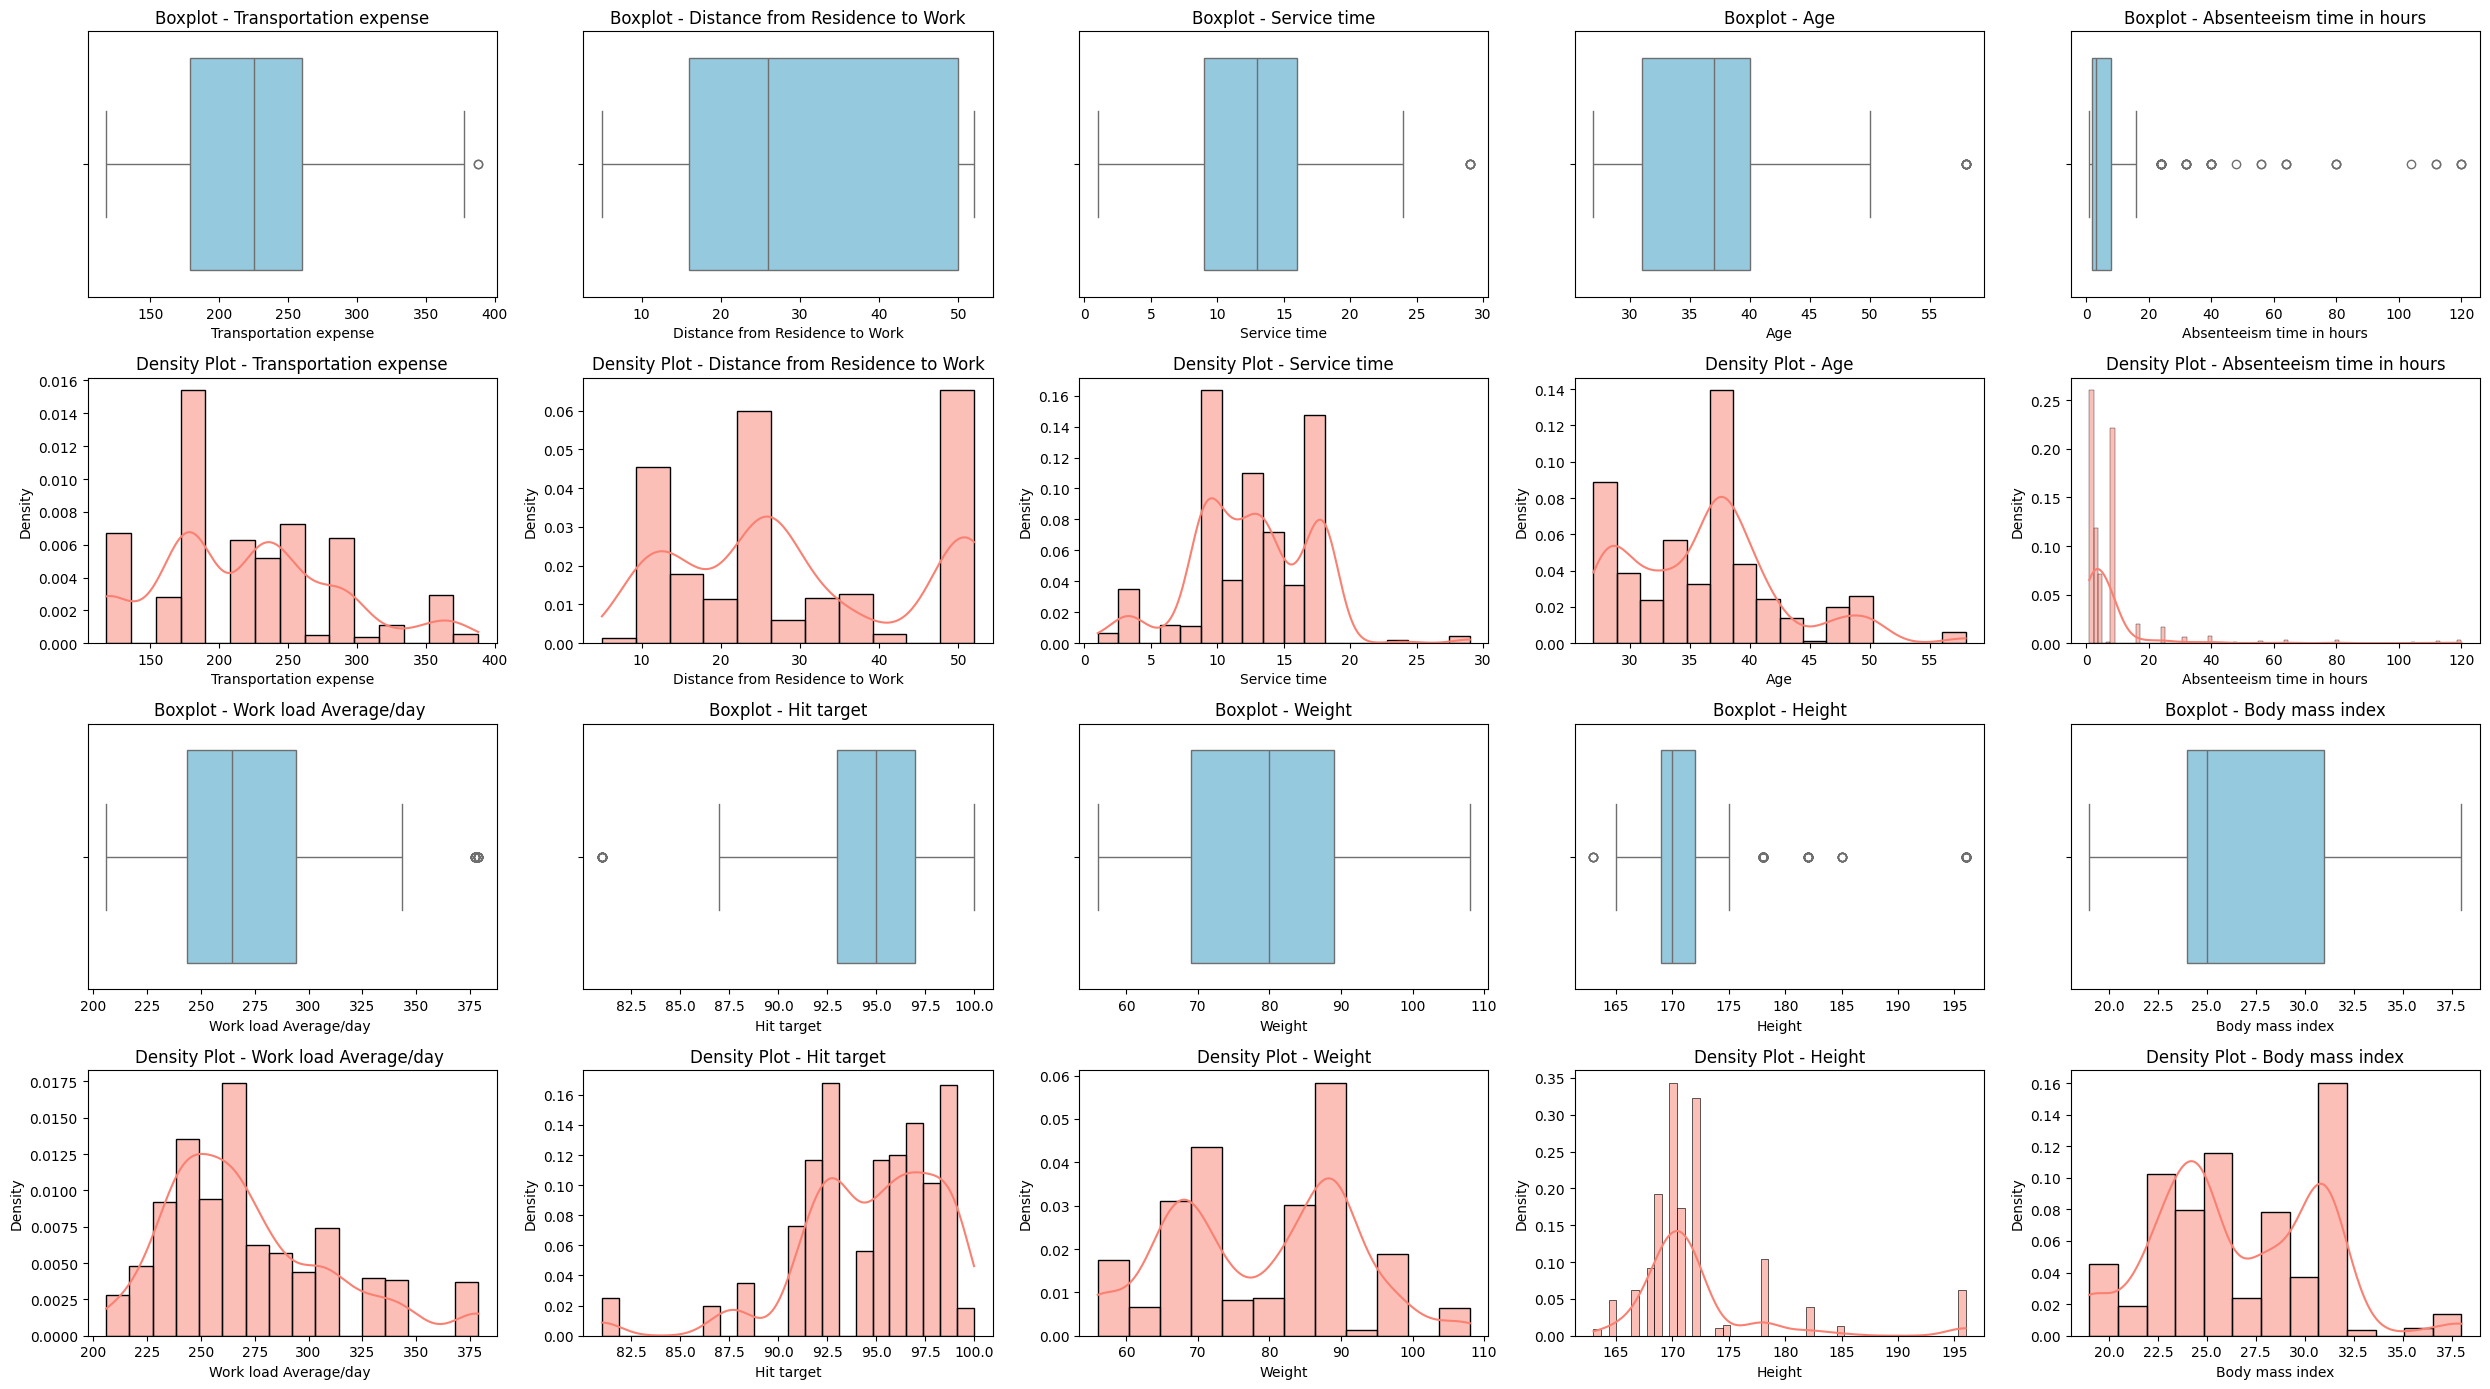

In [17]:
# Plot boxplot and density chart
plt.figure(figsize=(25, 14))

for i, feature in enumerate(col, 1):
    boxplot_idx = i if i <= 5 else i + 5
    histplot_idx = i + 5 if i <= 5 else i + 10

    # Boxplot
    plt.subplot(4, 5, boxplot_idx)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot - {feature}')

    # Histogram
    plt.subplot(4, 5, histplot_idx)
    sns.histplot(df[feature], kde=True, stat="density", color='salmon')
    plt.title(f'Density Plot - {feature}')

plt.tight_layout()
plt.show()

**Key observations**
* The absenteeism (target varaible) is highly skewed, as most absences are concentrated around 10 hours or less. This is suboptimal for linear models. Possible solutions to improve the analysis include:
 1. Applying a log transformation
 2. Training a model that handles non-linearity better (e.g., Random Forest)
 3. Switching to a classification approach
* There are some potential outliers that require further attention.
* Transportation expense, service time, and age appear to have relatively well-shaped distributions.
* Body Mass Index (BMI) is derived from height and weight, so some correlation is expected.
* Service time and age may be correlated, as older employees are generally more experienced.
* The workload distribution is slightly positively skewed, suggesting that most employees have a relatively low workload.
* Most employees perform very well, as indicated by the negatively skewed performance score distribution.

### Outlier analysis

In [18]:
#outliers_dict = {}

for c in col:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.loc[(df[c] < lower_bound) | (df[c] > upper_bound)].drop_duplicates().sort_values(c, ascending=False)
    print(f"OUTLIERS: {c} \n {outliers}\n")

OUTLIERS: Transportation expense 
      ID  Reason for absence  Month of absence  Day of the week  \
144  31                  11                 2                2   
145  31                   1                 2                3   

     Transportation expense  Distance from Residence to Work  Service time  \
144                     388                               15             9   
145                     388                               15             9   

     Age  Work load Average/day   Hit target  ...  Education  Son  \
144   50                 302.585          99  ...          1    0   
145   50                 302.585          99  ...          1    0   

     Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
144               0              0    0      76     178               24   
145               0              0    0      76     178               24   

     Absenteeism time in hours  Season  
144                          8       3  
145         

**Key observations**

* The outliers in absenteeism hours are spread across many employees and span a wide range of values. They cannot be considered anomalies, as they are primarily related to medical reasons. Moreover, the other variables fall within typical ranges, indicating that extreme absenteeism is not strongly linked to them.
* Outliers in transportation expense, service time, age, workload average per day, hit target, and height appear to be associated with either low absenteeism or high absenteeism due to medical reasons. Therefore, these data points seem to be justified.
* No significant outliers are observed in distance from work and weight.

### Categorical variable analysis

In [19]:
categorical_cols = [
    'Reason for absence', 'Month of absence', 'Day of the week', 'Season',
    'Disciplinary failure', 'Education', 'Son', 'Social drinker',
    'Social smoker', 'Pet'
]

for col in categorical_cols:
    print(f"Value counts for {col}:")
    counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)})
    print(summary)
    print("\n" + "-"*40 + "\n")


Value counts for Reason for absence:
                    Count  Percentage
Reason for absence                   
23                    149       21.41
28                    112       16.09
27                     68        9.77
13                     55        7.90
19                     40        5.75
22                     38        5.46
26                     33        4.74
25                     31        4.45
11                     26        3.74
10                     25        3.59
18                     21        3.02
14                     19        2.73
1                      16        2.30
7                      15        2.16
6                       8        1.15
12                      8        1.15
21                      6        0.86
8                       6        0.86
9                       4        0.57
5                       3        0.43
16                      3        0.43
24                      3        0.43
15                      2        0.29
4            

C:\Users\Stefano\AppData\Local\Temp\ipykernel_12208\3143378360.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=binned_reason_index, order=order, palette='Set2', legend=False)


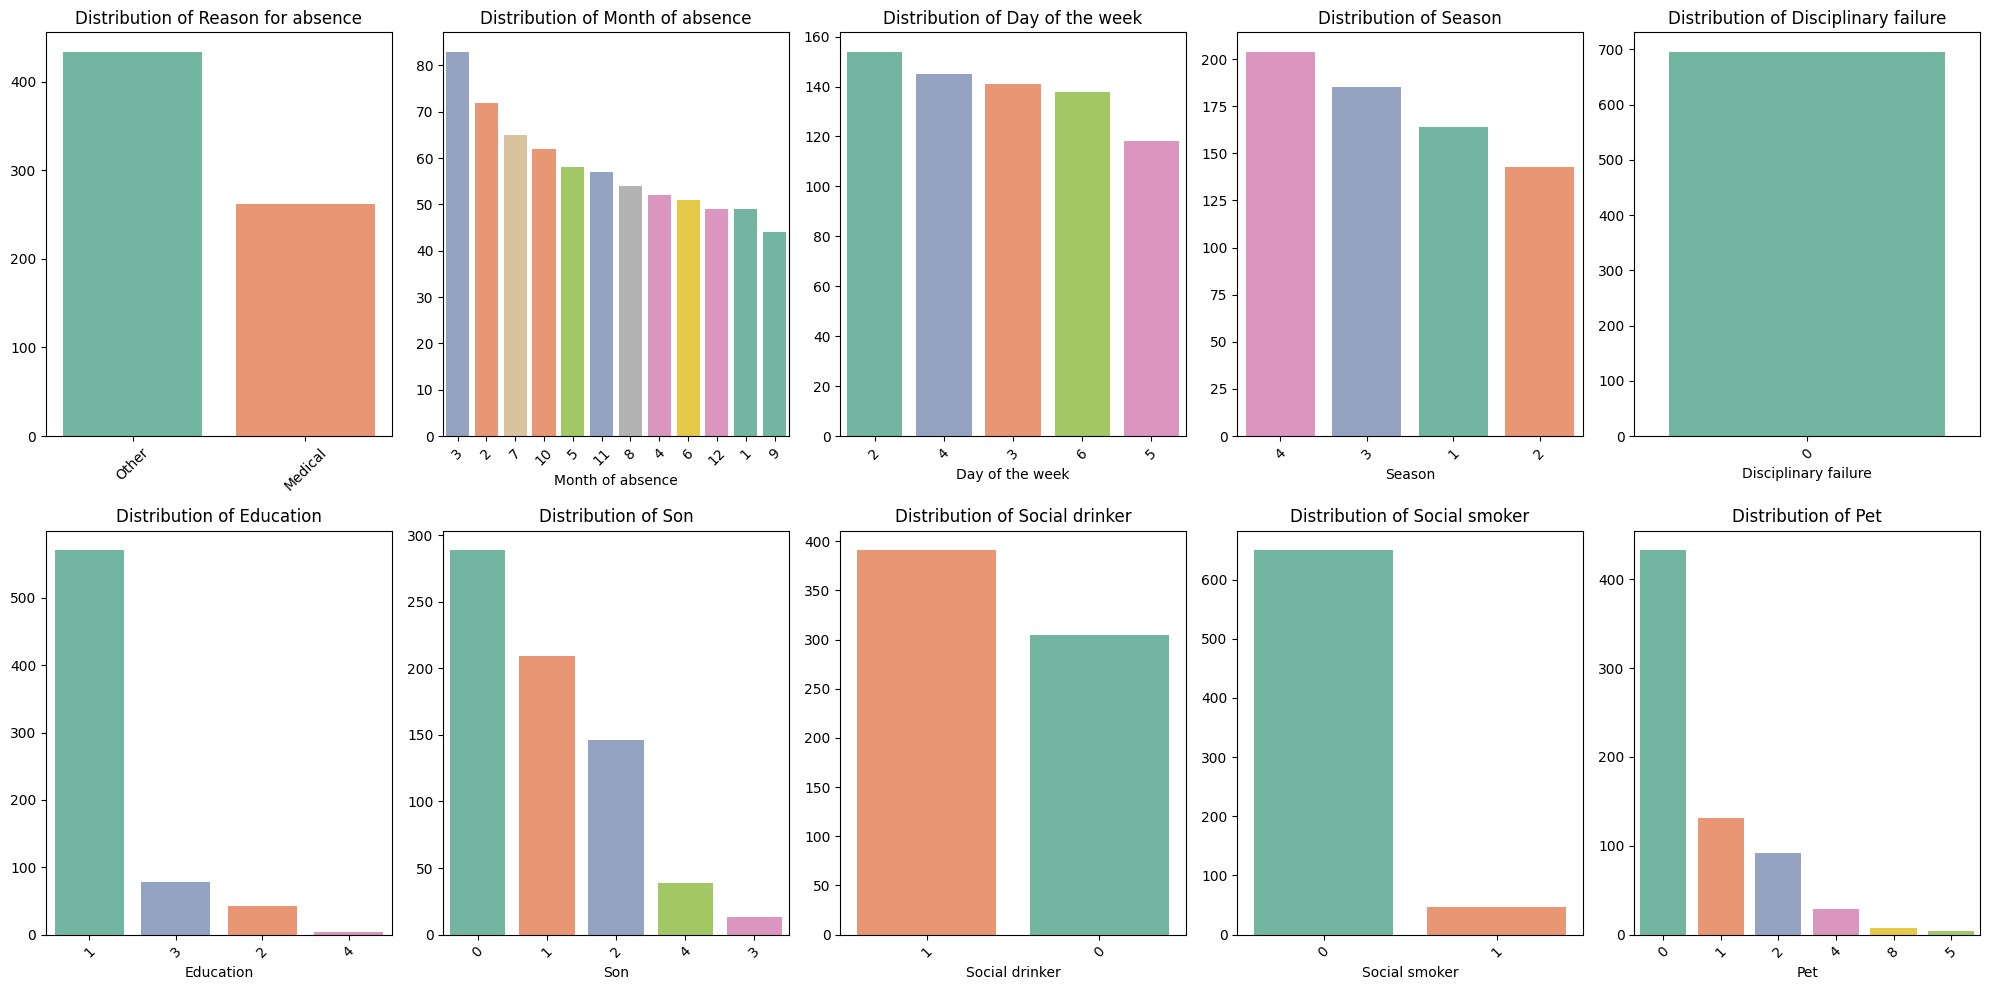

In [20]:
# Group the reason of absence
bins = [1, 21, 28]
labels = ['Medical', 'Other']
reasons = df['Reason for absence']
binned_reason_index = pd.cut(
            reasons,
            bins=bins,
            labels=labels,
            right=True,
            include_lowest=True,
            ordered=True # Ensure categories are ordered for plotting
        )

# Plot
plt.figure(figsize=(20, 10))

plt.subplot(2, 5, 1)
order = binned_reason_index.value_counts().index
sns.countplot(x=binned_reason_index, order=order, palette='Set2', legend=False)
plt.title(f'Distribution of {categorical_cols[0]}')
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=45)

for i, col in enumerate(categorical_cols[1:], 2):
    plt.subplot(2, 5, i)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, palette='Set2', hue=col, legend=False)
    plt.title(f'Distribution of {col}')
    plt.ylabel(None)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Key observations**

* Although medical reasons are common among the outliers, absences for other reasons represent the majority overall.
* There appears to be some seasonality in absenteeism, with peaks in late winter/early spring and mid-to-late summer/fall. This may be linked to seasonal illnesses, holidays, or specific business cycles.
* Absences are relatively evenly distributed across weekdays, with slightly higher counts at the beginning and at end of the week, consistently with the "weekend effect".
* Disciplinary failure is not a useful predictor, as it is constant across observations.
* Social smoker, education level, and pet ownership may have limited predictive value due to strong imbalance toward the lowest category.
* Most employees have either no children or one child; a typical distribution  for this type of demographic variable.
* Social drinker may be a useful predictor, as its distribution is more balanced across categories.

### Encoding of categorical variables

In [21]:
df["IsMedicalReasons"] = df["Reason for absence"].between(1, 21).astype(int)
df["IsEducation_Degree"] = df["Education"].isin([2, 3, 4]).astype(int)
df['HasSon'] = (df['Son'] > 1).astype(int)
df['IsDrinker'] = (df['Social drinker'] == 1).astype(int)
df['IsSmoker'] = (df['Social smoker'] == 1).astype(int)
df['HasPet'] = (df['Pet'] == 1).astype(int)

### Correlation matrix

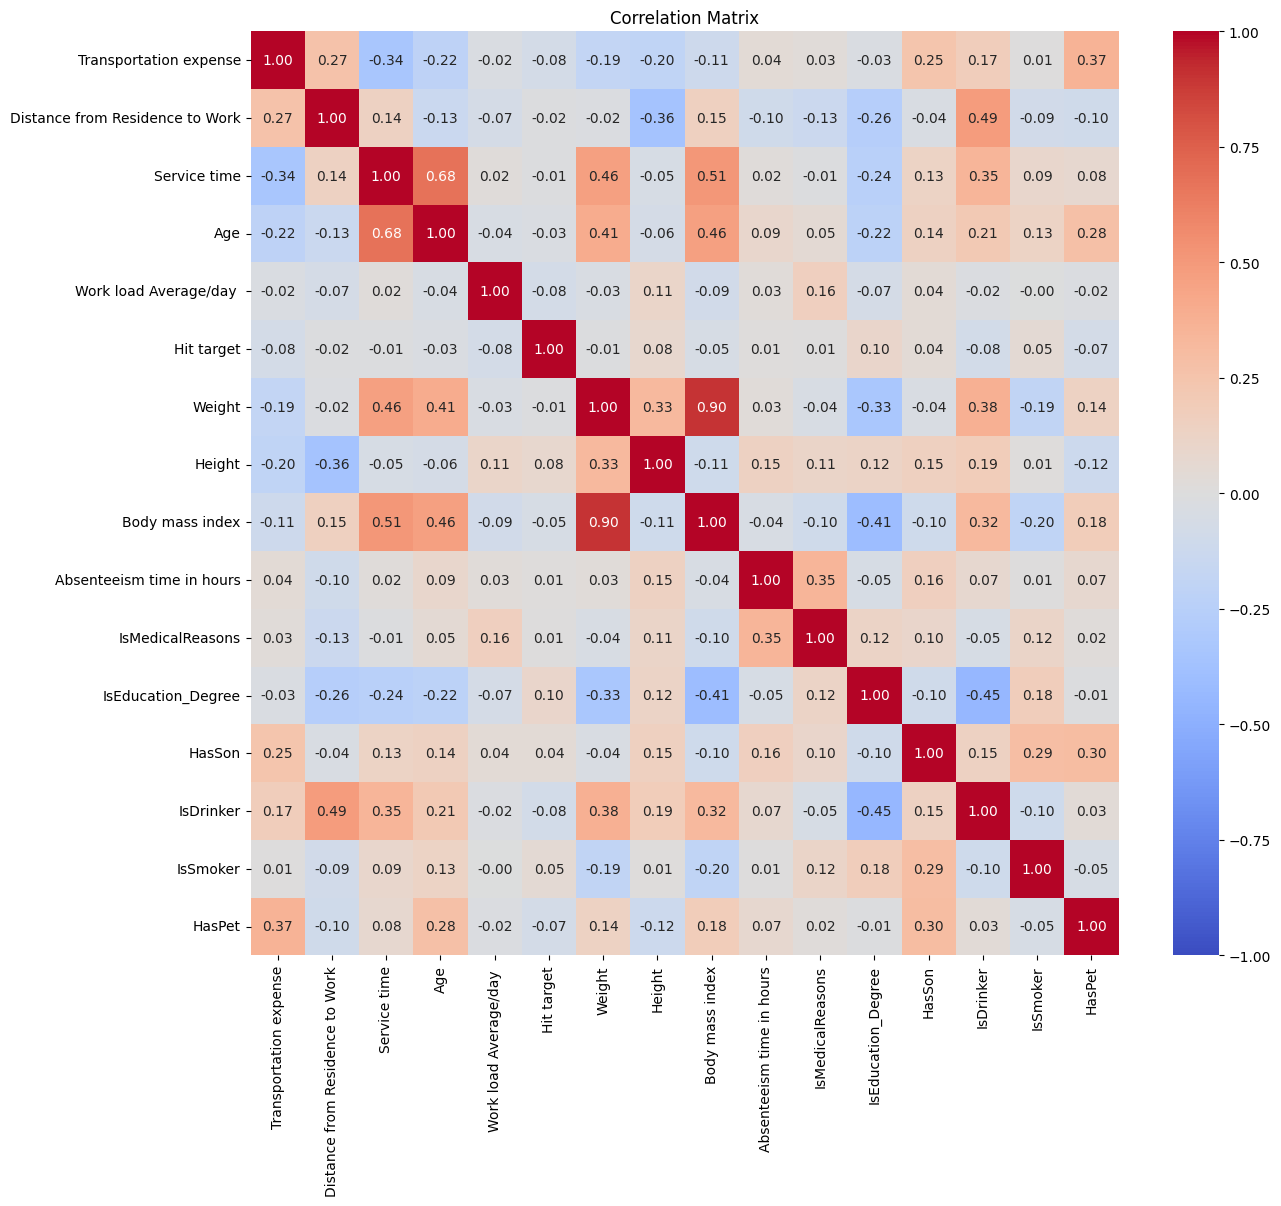

In [22]:
# # Drop not necessary columns (including the encoded variables)
drop_cols = ['ID','Month of absence','Day of the week','Season','Disciplinary failure','Reason for absence',"Education",'Son','Social drinker','Social smoker','Pet']

# Select numeric variables
numeric_df = df.drop(columns=drop_cols)

# Correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix")
plt.show()


**Key observations**

* Absenteeism shows very weak linear correlation with most variables.
* Features with a correlation of at least 0.07 were selected for the forecast:
  1.  Distance from Residence to Work
  2.  Height
  3.  IsMedicalReasons,
  4.  HasSon
  5.  Age
  6.  IsDrinker
  7.  HasPet


## Regression Modeling

### Target variable - Features - Dataset splitting

In [23]:
# Target variable (log)
y = np.log(df['Absenteeism time in hours'])

# Selected features
features = ['Distance from Residence to Work', 'Height','IsMedicalReasons','HasSon','Age','IsDrinker','HasPet']
X = df[features]

# Train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### Linear Regression

Mean-squared error: 0.723
R2: 0.194

---------------------------------------------

Coefficients estimated:
                            Feature     Coeff
0  Distance from Residence to Work -0.006018
1                           Height -0.010772
2                 IsMedicalReasons  0.988976
3                           HasSon  0.376595
4                              Age -0.018308
5                        IsDrinker  0.428334
6                           HasPet  0.024441
7                        Intercept  3.372649

---------------------------------------------

Diagnostic:



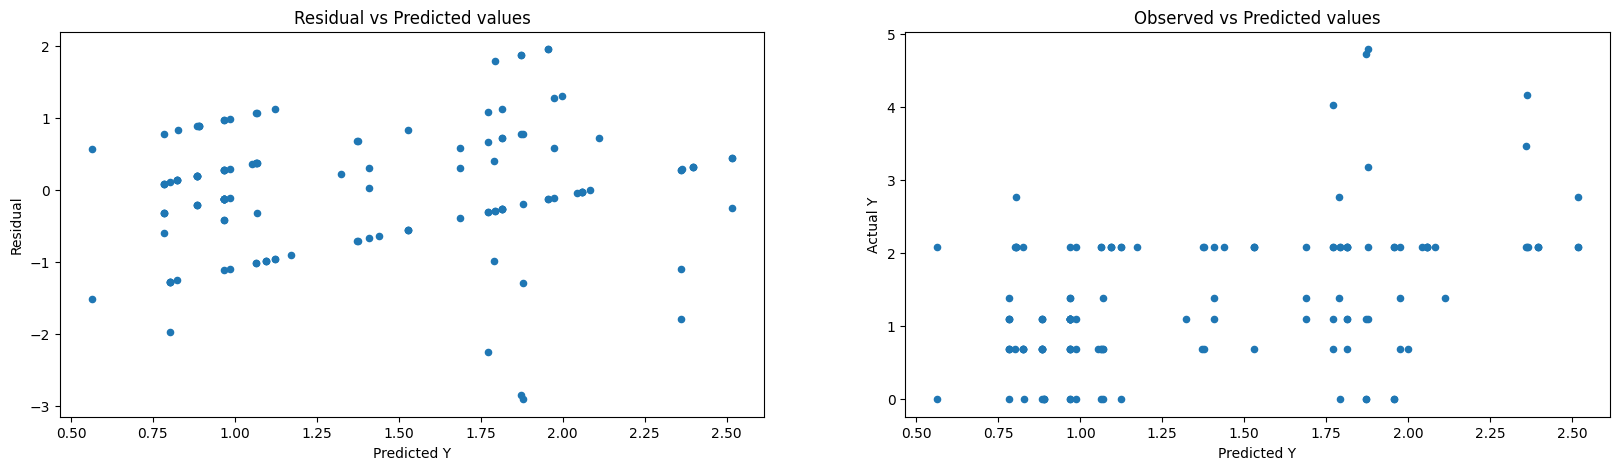

In [24]:
# Linear Regression model
model = LinearRegression()

# Fit
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Coefficients
coef = model.coef_
interc = model.intercept_

feature_coef = pd.DataFrame({'Feature': features, 'Coeff': coef})
feature_coef.loc[len(feature_coef)] = ['Intercept', interc]

# Residuals
residuals = y_pred - y_test

# Print prediction scores
print(f"Mean-squared error: {mse:.3f}\nR2: {r2:.3f}\n")
print("---------------------------------------------\n")
print(f"Coefficients estimated:\n {feature_coef}\n")
print("---------------------------------------------\n")

# Plot diagnostic
print('Diagnostic:\n')
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, s=20)
plt.xlabel("Predicted Y")
plt.ylabel("Residual")
plt.title("Residual vs Predicted values")

plt.subplot(1, 2, 2)
plt.scatter(y_pred, y_test, s=20)
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")
plt.title("Observed vs Predicted values")

plt.show()

**Key observations**

+ The model fits the data poorly, with the features explaining less than 20% of the variance.
* The residuals are not randomly distributed around zero and mostly follow a systematic upward trend.
* The predictions tend to cluster around a narrow range of observed values.
* The model systematically underpredicts the highest observations.

**Understanding the result**

* The main factor contributing to the model’s low performance is the nature of the absenteeism variable: discrete and heavily concentrated at low values, making it difficult for a linear model to fit the data effectively.
* Most features are also discrete, which further limits the model’s capacity to capture underlying patterns and relationships.

### Random Forest (regression)

Mean-squared error: 0.72
R2: 0.20

------------------------------------------



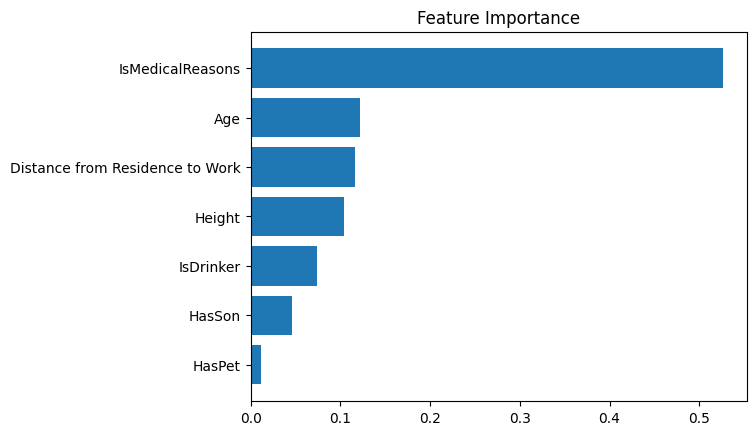

In [25]:
# Parameters
n = 1000
max_depth_list = [10, 20, 30, 40]
min_sample_split_list = [5, 10, 15, 20, 25]

combinations = product(max_depth_list, min_sample_split_list)

# Random Forest model

# Iterate the parameters
best_r2 = float("-Inf")
for d, ms in combinations:
  # Model
  model = RandomForestRegressor(
      random_state=12,
      n_estimators=n,
      max_depth=d,
      min_samples_split=ms)
  # Fit
  model.fit(X_train, y_train)
  # Predicted Values
  y_pred = model.predict(X_test)
  # R2
  new_r2 = r2_score(y_test, y_pred)
  # Check R2
  if new_r2 >= best_r2:
    best_r2 = new_r2
    # MSE
    mse = mean_squared_error(y_test, y_pred)
    # Feature Importance
    importance = model.feature_importances_

# Print prediction scores
print(f"Mean-squared error: {mse:.2f}\nR2: {best_r2:.2f}\n")
print("------------------------------------------\n")

# Feature Importance dataframe
chart_data = pd.Series(importance, index=X.columns).sort_values(ascending=True)

# Plot Feature mportance
plt.barh(chart_data.index, chart_data)
plt.title("Feature Importance")
plt.show()

**Understanding the result**
* The medical reason variable provides the most significant contribution, while the other features each contribute roughly 1%.
* The Random Forest model does not improve the overall performance, as shown by R-squared and MSE, indicating that the underlying data structure is more complex than expected.

## Classification

### Target variable

In [26]:
# Median absenteism
med_absenteism = df['Absenteeism time in hours'].median()

# Binary variable: absences above/below the median.
df['Absenteism_Binary'] = df['Absenteeism time in hours'].apply(lambda x:  1 if x > med_absenteism else 0)

y = df['Absenteism_Binary']

print(y.value_counts())

Absenteism_Binary
0    357
1    339
Name: count, dtype: int64


### Correlation matrix

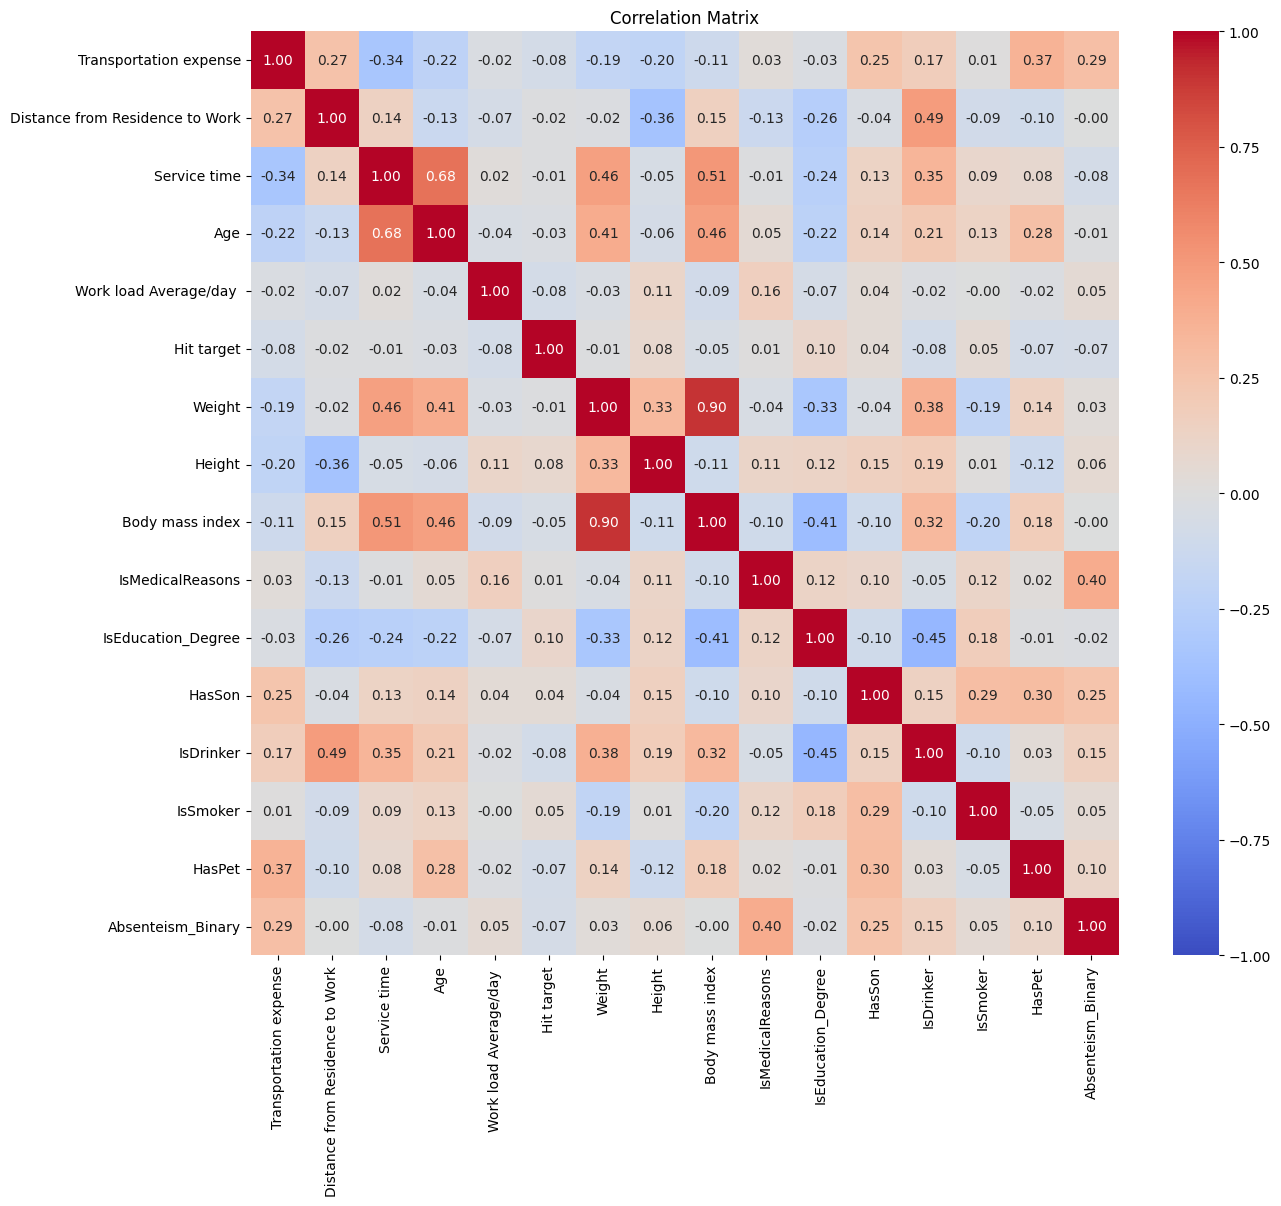

In [27]:
# Columns to exclude (including the encoded variables)
drop_cols = ['ID','Month of absence','Day of the week','Season','Disciplinary failure','Reason for absence',"Education",'Son','Social drinker','Social smoker','Pet','Absenteeism time in hours']

corr_matrix = df.drop(columns=drop_cols).corr()
#data = df[cols].corr()

#Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix")
plt.show()

**Key observations**

Features with a correlation of at least 0.07 were selected for the forecast:

  1. Transportation expense
  2. Service time
  3. Hit target
  4. HasSon
  5. IsDrinker
  6. HasPet
  7. IsMedicalReasons

### Features - Dataset splitting

In [28]:
# Selected features
features = ['Transportation expense', 'Service time','Hit target','HasSon','IsDrinker','HasPet','IsMedicalReasons']
X = df[features]

# Get train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=12)

### Logistic Regression

C:\Users\Stefano\AppData\Local\Temp\ipykernel_12208\1442693071.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = res_df.groupby('bin').agg(



Coefficients estimated:
                   Feature     Coeff
0  Transportation expense  0.008928
1            Service time -0.029489
2              Hit target -0.043068
3                  HasSon  0.757886
4               IsDrinker  0.734926
5                  HasPet -0.249519
6        IsMedicalReasons  1.972068
7               Intercept  1.100299

-------------------------------------------------------

Diagnostic:



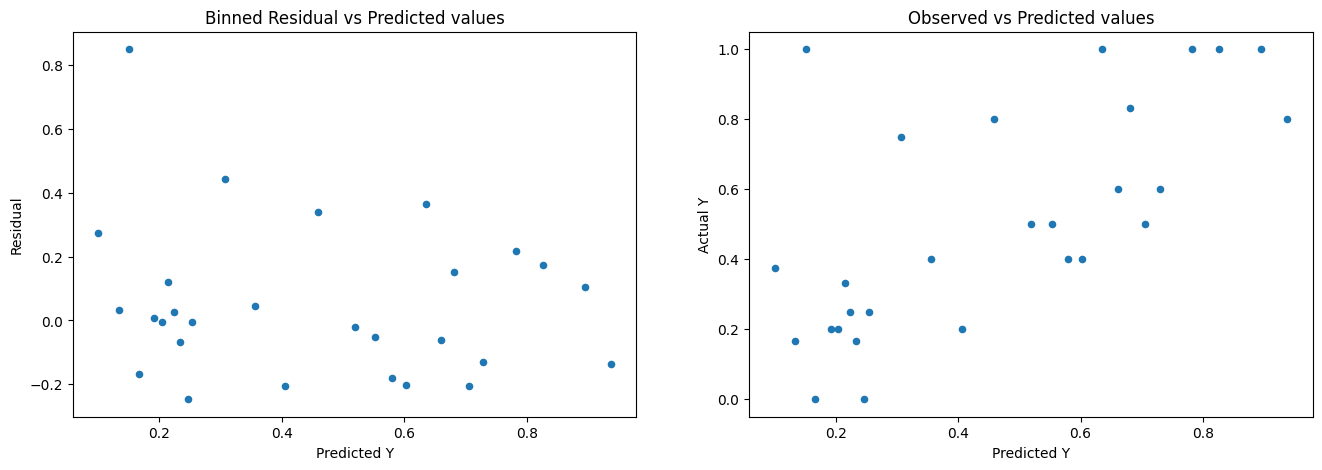


-------------------------------------------------------

Classificatoin scores for different threshold probabilities (P):
     Accuracy  Recall  Precision    F1
P                                     
0.3      0.72    0.82       0.67  0.74
0.4      0.71    0.75       0.69  0.72
0.5      0.71    0.68       0.72  0.70
0.2      0.58    0.91       0.54  0.68
0.6      0.71    0.56       0.79  0.66
0.7      0.66    0.35       0.86  0.50
0.8      0.61    0.22       0.94  0.36
0.9      0.56    0.10       0.88  0.18


In [29]:
# Logistic model
model = LogisticRegression(max_iter=1000)

# Fit
model.fit(X_train, y_train)

# Coefficients
coef = model.coef_
interc = model.intercept_[0]

feature_coef = pd.DataFrame({'Feature': features, 'Coeff': coef[0]})
feature_coef.loc[len(feature_coef)] = ['Intercept', interc]

# Predicted probabilities
y_prob_lg = model.predict_proba(X_test)[:, 1]

# Binned residuals
res_df = pd.DataFrame({'Residual': y_test - y_prob_lg, 'Pred_prob': y_prob_lg, 'Obs_value': y_test})
num_bins = int(len(residuals)/5)
res_df['bin'] = pd.qcut(res_df['Pred_prob'], q=num_bins, duplicates='drop')
binned = res_df.groupby('bin').agg(
    mean_pred_prob=('Pred_prob', 'mean'),
    mean_observed=('Obs_value', 'mean'),
    mean_residual=('Residual', 'mean'),
    count=('Residual', 'size')
)

# Scores
metrics = {'Accuracy': [], 'Recall': [], 'Precision': [], 'F1': []}

# Predict the binary outcome: loop over threshold probabilities
prob_cutoff = pd.Series(range(2, 10)).apply(lambda x: x / 10)
for c in prob_cutoff:
  y_pred = (y_prob_lg >= c).astype(int)
  accuracy = round(accuracy_score(y_test, y_pred), 2)
  recall = round(recall_score(y_test, y_pred), 2)
  precision = round(precision_score(y_test, y_pred), 2)
  f1 = round(f1_score(y_test, y_pred), 2)
  metrics['Accuracy'].append(accuracy)
  metrics['Recall'].append(recall)
  metrics['Precision'].append(precision)
  metrics['F1'].append(f1)

# Score Result
logistic_scores = pd.DataFrame(metrics, index=prob_cutoff)
logistic_scores.index.rename('P', inplace = True)

# Print the coefficients
print(f"\nCoefficients estimated:\n {feature_coef}\n")
print("-------------------------------------------------------\n")

print("Diagnostic:\n")
# Plot diagnostic
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(binned['mean_pred_prob'], binned['mean_residual'], s=20)
plt.xlabel("Predicted Y")
plt.ylabel("Residual")
plt.title("Binned Residual vs Predicted values")

plt.subplot(1, 2, 2)
plt.scatter(binned['mean_pred_prob'], binned['mean_observed'], s=20)
plt.xlabel("Predicted Y")
plt.ylabel("Actual Y")
plt.title("Observed vs Predicted values")

plt.show()

# Print classification scores
print("\n-------------------------------------------------------\n")
print(f"Classificatoin scores for different threshold probabilities (P):")
print(f"{logistic_scores.sort_values('F1', ascending=False)}")

**Key observations**

Coefficients:
* Having a son and being a social drinker increase the log-odds, possibly reflecting family-related absences, while having pet has a negative impact.
* Medical reasons have a strong positive impact and it is by far the strongest predictor
* Employees who hit performance targets are less likely to be absent.
* Transportation expense has minimal impact.

Diagnostic:
* The residuals show some weak patterns but overall they are spread randomly around 0, suggesting reasonable model calibration.
* For lower predicted probabilities, many residuals are negative, indicating the model may be slightly overpredicting in these ranges.
* In the right chart, the data points align closely with an upward linear trend, supporting a generally good fit between predicted probabilities and actual outcomes.

Classification:

* A cut-off probability of 0.3 yields both the highest accuracy (0.72) and the best F1-score (0.74).
* The highest recall (0.91) is achieved at a threshold of 0.2, while the highest precision (0.94) is reached at a threshold of 0.8.


### Random Forest (classification)

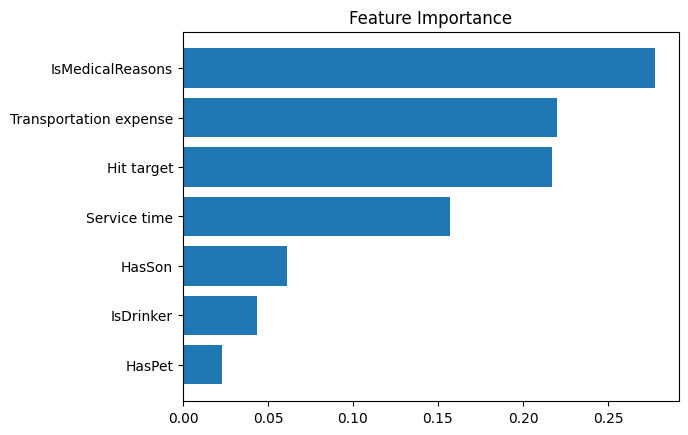


------------------------------------------------------------
Classificatoin scores for different threshold probabilities (P):
     Accuracy  Recall  Precision    F1
P                                     
0.5      0.76    0.78       0.74  0.76
0.3      0.70    0.90       0.64  0.74
0.2      0.65    0.96       0.59  0.73
0.4      0.71    0.82       0.66  0.73
0.6      0.75    0.66       0.79  0.72
0.7      0.67    0.38       0.87  0.53
0.8      0.60    0.19       0.93  0.32
0.9      0.56    0.09       1.00  0.16


In [30]:
# Feature selection

# Parameters
n = 1000
max_depth_list = [10, 20, 30, 40]
min_sample_split_list = [5, 10, 15, 20, 25]

combinations = product(max_depth_list, min_sample_split_list)

# Random Forest model

# Iterate the parameters
best_f1 = float("-Inf")
for d, ms in combinations:
  # Model
  model = RandomForestClassifier(
      random_state=12,
      n_estimators=n,
      max_depth=d,
      min_samples_split=ms)
  # Fit
  model.fit(X_train, y_train)
  # Predicted values
  y_pred = model.predict(X_test)
  # F1-score
  new_f1 = f1_score(y_test, y_pred)
  # Check F1-score
  if new_f1 >= f1:
    f1 = new_f1
    # Feature importance
    importance = model.feature_importances_

# Feature Importance dataframe
chart_data = pd.Series(importance, index=X.columns).sort_values(ascending=True)

# Predicted probabilities
y_prob_rf = model.predict_proba(X_test)[:, 1]

# # Cut-off probabilities
# prob_cutoff = pd.Series(range(1, 10)).apply(lambda x: x / 10)

# Scores
metrics = {'Accuracy': [], 'Recall': [], 'Precision': [], 'F1': []}

# Predict the binary outcome: loop over threshold probabilities
prob_cutoff = pd.Series(range(2, 10)).apply(lambda x: x / 10)
for c in prob_cutoff:
  y_pred = (y_prob_rf >= c).astype(int)
  accuracy = round(accuracy_score(y_test, y_pred), 2)
  recall = round(recall_score(y_test, y_pred), 2)
  precision = round(precision_score(y_test, y_pred), 2)
  f1 = round(f1_score(y_test, y_pred), 2)
  metrics['Accuracy'].append(accuracy)
  metrics['Recall'].append(recall)
  metrics['Precision'].append(precision)
  metrics['F1'].append(f1)

# Score Result
random_f_scores = pd.DataFrame(metrics, index=prob_cutoff)
random_f_scores.index.rename('P', inplace=True)

# Plot Feature Importance
plt.barh(chart_data.index, chart_data)
plt.title("Feature Importance")
plt.show()

# Print classification scores
print("\n------------------------------------------------------------")
print(f"Classificatoin scores for different threshold probabilities (P):\n{random_f_scores.sort_values('F1', ascending=False)}")

**Key observations**

Features:

* IsMedicalReasons is the most important feature, indicating that the reason for absence is the primary driver of the predictions.
* Transportation expense and Hit target provide similar levels of contribution.
* IsDrinker and HasPet each contribute for less than 5%.

Classification:

* The default probability threshold (0.5) yields the highest accuracy and F1-score.
* The highest recall is achieved at a threshold of 0.2, while the highest precision is reached at 0.9.

### Compare classificators

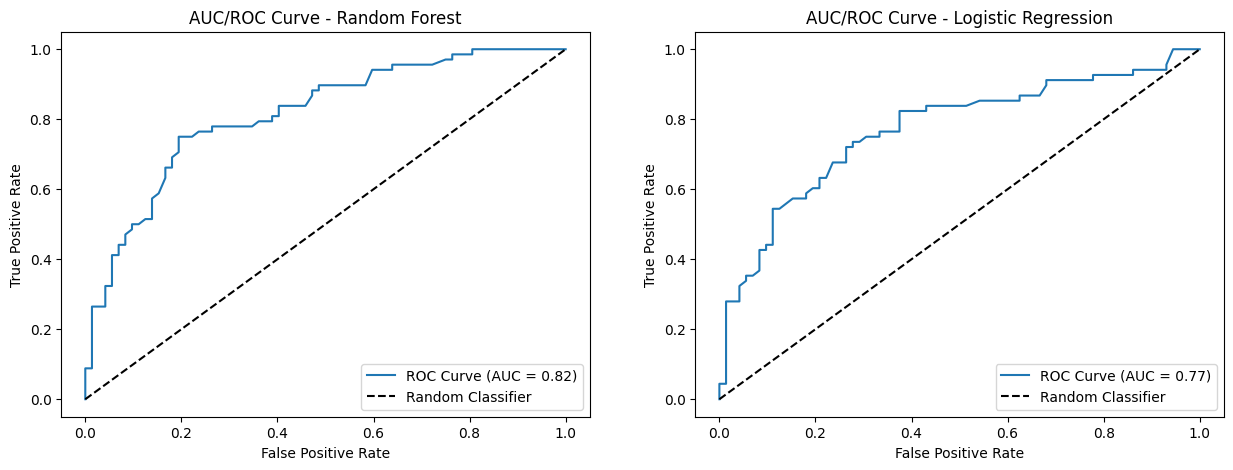


-------------------------------------------------------

Score comparison:
           Random Forest  Logistic Model
F1                  0.76            0.74
Recall              0.78            0.82
Precision           0.74            0.67
Accuracy            0.76            0.72
P                   0.50            0.30



In [31]:
# ROC curve - Random Forest
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob_rf)
auc_score_rf = roc_auc_score(y_test, y_prob_rf)

# ROC curve - Logistic Regression
fpr_lg, tpr_lg, thresholds = roc_curve(y_test, y_prob_lg)
auc_score_lg = roc_auc_score(y_test, y_prob_lg)

# Scores
compare_scores = pd.concat([
    random_f_scores.sort_values('F1', ascending=False).reset_index().iloc[0],
    logistic_scores.sort_values('F1', ascending=False).reset_index().iloc[0]],
    axis=1
)
compare_scores.columns = ['Random Forest','Logistic Model']
compare_scores = compare_scores.reindex(['F1','Recall','Precision','Accuracy','P'])

# Plot curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {auc_score_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC/ROC Curve - Random Forest')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_lg, tpr_lg, label=f'ROC Curve (AUC = {auc_score_lg:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC/ROC Curve - Logistic Regression')
plt.legend(loc='lower right')

plt.show()

# Print classification score comparison
print("\n-------------------------------------------------------")
print(f"\nScore comparison:\n{compare_scores}\n")

**Understanding the result**

AUC/ROC:
* The ability to distinguish between the positive class (Absenteeism > Median) and negative class (Absenteeism ≤ Median), is similar for both models, although the ROC curve for the logistic model leans slightly closer to the random classifier line.

Classification:
* The Random Forest outperforms the Logistic model across all metrics except recall.
* The Logistic model achieves a higher F1-score, but at the cost of significantly lower precision.
* The Random Forest offers the best compromise, delivering strong overall performance and handling the precision–recall trade-off more effectively.

Overall, the Random Forest model demonstrated the best performance, offering the most reliable predictive power for forecasting absenteeism.